In [1]:
import cv2
import numpy as np
import os
import copy
import sys
import math
import torch
import matplotlib.pyplot as plt
import time

In [2]:
BASE_DIR = "/home/denso/carlos_vsr_workspace/mapfe4mp"
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset_utils as dataset_utils
import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.map_functions as map_functions 
import model.datasets.argoverse.goal_points_functions as goal_points_functions                                              

from argoverse.map_representation.map_api import ArgoverseMap

avm = ArgoverseMap()

INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap


In [3]:
# Load files

dataset_path = "data/datasets/argoverse/motion-forecasting/"
split = "train"
split_folder = BASE_DIR + "/" + dataset_path + split
data_folder = BASE_DIR + "/" + dataset_path + split + "/data/"
data_images_folder = BASE_DIR + "/" + dataset_path + split + "/data_images"

files, num_files = dataset_utils.load_list_from_folder(data_folder)

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Num files:  205942


In [4]:
# N.B. In this cell you can modify the map_generator in order to test your new map representation. Once 
# you have your desired representation, modify the function in model.dataset.argoverse.map_functions

from argoverse.utils.centerline_utils import (
    centerline_to_polygon
)

def map_generator(curr_num_seq,
                  origin_pos,
                  offset,
                  avm,
                  city_name,
                  show: bool = False,
                  root_folder = "data/datasets/argoverse/motion-forecasting/train/data_images") -> None:
    """
    """

    if not os.path.exists(root_folder):
        print("Create experiment path: ", root_folder)
        os.mkdir(root_folder)

    plot_centerlines = True
    plot_local_das = False
    plot_local_lane_polygons = False

    xcenter, ycenter = origin_pos[0], origin_pos[1]
    x_min = xcenter + offset[0]
    x_max = xcenter + offset[1]
    y_min = ycenter + offset[2]
    y_max = ycenter + offset[3]

    # Get map info 

    ## Get centerlines around the origin

    t0 = time.time()

    seq_lane_props = dict()
    if plot_centerlines:
        seq_lane_props = avm.city_lane_centerlines_dict[city_name]

    ### Get lane centerlines which lie within the range of trajectories

    lane_centerlines = []
    
    for lane_id, lane_props in seq_lane_props.items():

        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max
            and np.min(lane_cl[:, 1]) < y_max
            and np.max(lane_cl[:, 0]) > x_min
            and np.max(lane_cl[:, 1]) > y_min):

            lane_centerlines.append(lane_cl)

    ## Get local polygons around the origin

    local_lane_polygons = []
    if plot_local_lane_polygons:
        local_lane_polygons = avm.find_local_lane_polygons([x_min, 
                                                            x_max, 
                                                            y_min, 
                                                            y_max], 
                                                            city_name)
    #pdb.set_trace()
    ## Get drivable area around the origin

    local_das = []
    if plot_local_das:
        local_das = avm.find_local_driveable_areas([x_min, 
                                                    x_max, 
                                                    y_min, 
                                                    y_max], 
                                                    city_name)

    # print("\nTime consumed by local das and polygons calculation: ", time.time()-t0)

    # Plot

    fig, ax = plt.subplots(figsize=(6,6), facecolor="black")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.axis("off") # Comment if you want to generate images without x|y-labels
    
    ## Plot nearby segments

    # avm.plot_nearby_halluc_lanes(ax, city_name, xcenter, ycenter)

    ## Plot hallucinated polygones and centerlines

    t0 = time.time()

    for lane_cl in lane_centerlines:
        lane_polygon = centerline_to_polygon(lane_cl[:, :2])
                                                                          #"black"  
        ax.fill(lane_polygon[:, 0], lane_polygon[:, 1], "white", edgecolor='white', fill=True)
                                                        #"grey"
        ax.plot(lane_cl[:, 0], lane_cl[:, 1], "-", color="grey", linewidth=1.5, alpha=1.0, zorder=2)
        # N.B. zorder must be 2 (Line2D) in order to represent the whole line, with 1 (Path) there are some problems

    # print("Time consumed by plot drivable area and lane centerlines: ", time.time()-t0)

    # draw_lane_polygons(ax, local_das, "tab:pink", linewidth=1.5, fill=False)
    # draw_lane_polygons(ax, local_lane_polygons, "tab:red", linewidth=1.5, fill=False)

    # Save image

    filename = root_folder + "/" + str(curr_num_seq) + ".png"

    if show:
        plt.show()
        pdb.set_trace()

    # Save PLT canvas -> png to automatically remove padding

    plt.savefig(filename, bbox_inches='tight', facecolor=fig.get_facecolor(), 
                edgecolor='none', pad_inches=0)

In [24]:
def change_bg_color(img):
    img[np.all(img == (0, 0, 0), axis=-1)] = (255,255,255)

    return img

In [208]:
def plot_fepoints(img, filename, seq_px_x, seq_px_y, last_obs_px, obs_origin, 
                  goals_px_x=None, goals_px_y=None, label=None,
                  radius=None, change_bg=False, show_pred_gt=False, show=False, save_fig=False, final_clusters=False):
    assert len(img.shape) == 3
    
    img_aux = copy.deepcopy(img)
    fig, ax = plt.subplots(figsize=(8, 8))

    obs_px_x, obs_px_y = seq_px_x[:obs_origin], seq_px_y[:obs_origin]

    if show_pred_gt:
        plt.scatter(seq_px_x[obs_origin:], seq_px_y[obs_origin:], c="cyan", marker=6, s=50) # GT future trajectory
        
    plt.scatter(obs_px_x, obs_px_y, c="blue", marker=".", s=50) # Past trajectory
    plt.scatter(last_obs_px[0], last_obs_px[1], c="blue", marker="*", s=100) # Last observation point
    
    if goals_px_x is not None:
        if label is not None:
            u_labels = np.unique(label) # get unique labels
            for i in u_labels:
                if final_clusters: goal_size=80
                else: goal_size = 10
                plt.scatter(goals_px_x[label == i] , goals_px_y[label == i] , 
                            label = i, marker="8", s=goal_size) # Goal points clustered
        else:
            plt.scatter(goals_px_x, goals_px_y, color="purple", marker="8", s=10) # Goal points

    plt.imshow(img_aux)

    if radius:
      circ_car = plt.Circle((car_px[0], car_px[1]), radius, color="purple", fill=False)
      ax.add_patch(circ_car)

    plt.axis("off")

    if show:
        plt.title(filename) 
        plt.show()

    if change_bg:
        img_aux = change_bg_color(img)

    if save_fig:
        plt.savefig(filename, bbox_inches='tight', facecolor=fig.get_facecolor(), 
                    edgecolor='none', pad_inches=0)

    plt.close('all')

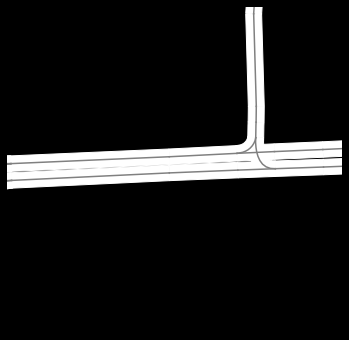

In [209]:
# Generate a rasterized representation of the map 
# (Just to illustrate the driveable area, not required in our algorithm)

import model.datasets.argoverse.map_functions as map_functions

file_id = "57" # Override this variable to compute a different local map
dist_around = 40 # m around the ego-vehicle
dist_rasterized_map = [-dist_around, dist_around, -dist_around, dist_around]  

path = os.path.join(root_file_name,str(file_id)+".csv")
data = dataset_utils.read_file(path) 

obs_origin = 20
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)
origin_pos = origin_pos[0].tolist() # [[x,y]] np.array -> [x,y] list

# map_functions.map_generator(file_id, 
map_generator(file_id,
                            origin_pos,
                            dist_rasterized_map,
                            avm,
                            city_name,
                            show=False,
                            root_folder=data_images_folder)

In [210]:
# Goal points hyperparameters

change_img_bg = False
num_initial_samples = 1000
pred_seconds = 3 # [seconds] To compute the goal points 
                 #           until pred_seconds ahead (assuming constant velocity)
NUM_GOAL_POINTS = 32
MAX_CLUSTERS = 6 # Maximum number of modes (multimodality)
MULTIMODAL = True 

In [211]:
# 0. Load image

filename = data_images_folder + "/" + str(file_id) + ".png"
real_world_offset = dist_around

img = cv2.imread(filename)
img = cv2.resize(img, dsize=(600,600))
height, width = img.shape[:2]
img_size = height
scale_x = scale_y = float(height/(2*real_world_offset))

cx = int(width/2)
cy = int(height/2)
car_px = (cy,cx)

In [212]:
# 1. Get past observations

obs_len = 20
pred_len = 30
seq_len = obs_len + pred_len
skip = 1
obs_origin = 20

frames = np.unique(data[:, 0]).tolist() 
frame_data = []
for frame in frames:
    frame_data.append(data[frame == data[:, 0], :]) # save info for each frame

num_sequences = int(math.ceil((len(frames) - seq_len + 1) / skip))
idx = 0

num_objs_considered, _non_linear_obj, curr_loss_mask, curr_seq, \
curr_seq_rel, id_frame_list, object_class_list, city_id, ego_origin = \
    dataset.process_window_sequence(idx, frame_data, frames, \
                            seq_len, pred_len, file_id, split, obs_origin)

In [213]:
# 2. Plot AGENT observed trajectory

goal_points_folder = split_folder + "/goal_points_test"

if not os.path.exists(goal_points_folder):
    print("Create goal points folder: ", goal_points_folder)
    os.makedirs(goal_points_folder) # makedirs creates intermediate folders

seq_id = file_id

agent_index = np.where(object_class_list == 1)[0].item()

# agent_obs_seq = curr_seq[agent_index,:,:obs_origin].transpose() # 20 x 2 ("abs" around 0)
agent_obs_seq = curr_seq[agent_index,:,:].transpose() # Whole sequence

agent_seq_global = agent_obs_seq + origin_pos # abs (hdmap coordinates)
agent_seq_global = torch.from_numpy(agent_seq_global)

# px = pixels
agent_px_points = goal_points_functions.transform_real_world2px(agent_seq_global, origin_pos, real_world_offset, img_size)
agent_px_x, agent_px_y = agent_px_points[:,0], agent_px_points[:,1] # TODO: Refactorize
filename = goal_points_folder + "/" + seq_id + "_step_1_sequence.png"
#goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, change_bg=change_img_bg)

plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True, save_fig=True, change_bg=change_img_bg)

In [214]:
# 3. Get feasible area points (N samples)

# 3.0. (Optional) Observe random sampling in the whole feasible area

rad = 1000 # meters. Cause we want to observe all points around the AGENT

fe_y, fe_x = goal_points_functions.get_points(img, car_px, scale_x, rad=10000, color=255, N=num_initial_samples, 
                        sample_car=True, max_samples=None) # return rows, columns
filename = goal_points_folder + "/" + seq_id + "_step_2_all_samples.png"
# goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_x, car_px, 
plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True,
                                    save_fig=True, goals_px_x=fe_x, goals_px_y=fe_y, change_bg=change_img_bg)

# 3.1. Filter using AGENT estimated velocity in the last observation frame

agent_obs_seq_global = agent_seq_global[:obs_origin,:]
mean_vel = goal_points_functions.get_agent_velocity(torch.transpose(agent_obs_seq_global,0,1))
radius = mean_vel * pred_seconds
radius_px = radius * scale_x	

fe_y, fe_x = goal_points_functions.get_points(img, car_px, scale_x, rad=radius_px, color=255, N=1024, 
                            sample_car=True, max_samples=None) # return rows, columns

filename = goal_points_folder + "/" + seq_id + "_step_3_vel_filter.png"
#goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True,
                                    save_fig=True, goals_px_x=fe_x, goals_px_y=fe_y, radius=radius_px, change_bg=change_img_bg)

# 3.1. Filter using AGENT estimated orientation (yaw) in the last observation frame

mean_yaw = goal_points_functions.get_agent_yaw(torch.transpose(agent_obs_seq_global,0,1)) # radians

if mean_yaw >= 0.0:
    angle = math.pi/2 - mean_yaw
elif mean_yaw < 0.0:
    angle = -(math.pi / 2 + (math.pi - abs(mean_yaw)))

c, s = np.cos(angle), np.sin(angle)
R = np.array([[c,-s], [s, c]])

fe_x_trans = fe_x - cx # get px w.r.t. the center of the image to be rotated
fe_y_trans = fe_y - cy

close_pts = np.hstack((fe_x_trans.reshape(-1,1),fe_y_trans.reshape(-1,1)))
close_pts_rotated = np.matmul(close_pts,R).astype(np.int32)

fe_x_rot = close_pts_rotated[:,0] + cx
fe_y_rot = close_pts_rotated[:,1] + cy

filtered_fe_x = fe_x[np.where(fe_y_rot < cy)[0]]
filtered_fe_y = fe_y[np.where(fe_y_rot < cy)[0]]

filename = goal_points_folder + "/" + seq_id + "_step_4_angle_filter.png"
#goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True,
                                    save_fig=True, goals_px_x=filtered_fe_x, goals_px_y=filtered_fe_y, radius=radius_px, change_bg=change_img_bg)                                  

In [215]:
# 4. Get furthest N samples (closest the the hypothetical radius)

dist = []
for i in range(len(filtered_fe_x)):
    d = math.sqrt(pow(filtered_fe_x[i] - car_px[0],2) + pow(filtered_fe_y[i] - car_px[1],2))
    dist.append(d)

dist = np.array(dist)

furthest_indeces = np.argsort(dist)
if len(furthest_indeces) > NUM_GOAL_POINTS:
    furthest_indeces = np.argsort(dist)[-NUM_GOAL_POINTS:]

final_samples_x, final_samples_y = filtered_fe_x[furthest_indeces], filtered_fe_y[furthest_indeces]

try:
    diff_points = NUM_GOAL_POINTS - len(final_samples_x)
    final_samples_x = np.hstack((final_samples_x, final_samples_x[0]+0.2 * np.random.randn(diff_points)))
    final_samples_y = np.hstack((final_samples_y, final_samples_y[0]+0.2 * np.random.randn(diff_points)))
except:
    final_samples_x = cx + scale_x*np.random.randn(NUM_GOAL_POINTS)
    final_samples_y = cy + scale_y*np.random.randn(NUM_GOAL_POINTS)

filename = goal_points_folder + "/" + seq_id + "_step_5_final_samples.png"
#goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True,
                                    goals_px_x=final_samples_x, goals_px_y=final_samples_y, radius=radius_px, change_bg=change_img_bg)

if len(final_samples_x) != NUM_GOAL_POINTS:
    print(f"Final samples does not match with {NUM_GOAL_POINTS} required samples")
    goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, 
                                        save_fig=True, goals_px_x=final_samples_x, goals_px_y=final_samples_y, radius=radius_px, change_bg=change_img_bg)

In [216]:
# 6. Clustering

final_samples = np.hstack((final_samples_x.reshape(-1,1),final_samples_y.reshape(-1,1)))
final_samples.shape

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# Initialize the class object
kmeans = KMeans(n_clusters = MAX_CLUSTERS)
 
# Predict the labels of clusters

label = kmeans.fit_predict(final_samples)

# Getting unique labels
 
u_labels = np.unique(label)

# goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
filename = goal_points_folder + "/" + seq_id + "_step_6_clustering.png"
plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True, 
              goals_px_x=final_samples_x, goals_px_y=final_samples_y, label=label, radius=radius_px, change_bg=change_img_bg,
              save_fig=True)

# Final clusters

aux = torch.zeros((MAX_CLUSTERS,2))
cont_goals = torch.zeros((MAX_CLUSTERS))

for i in range(final_samples.shape[0]):
    aux[label[i],0] += final_samples[i,0]
    aux[label[i],1] += final_samples[i,1]
    cont_goals[label[i]] += 1 # Num goals per cluster
aux = torch.div(aux,cont_goals.reshape(MAX_CLUSTERS,1))
label = torch.arange(MAX_CLUSTERS)

filename = goal_points_folder + "/" + seq_id + "_step_7_multimodal.png"
plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True, 
              goals_px_x=aux[:,0], goals_px_y=aux[:,1], label=label, radius=radius_px, change_bg=change_img_bg,
              save_fig=True, final_clusters=True)

rng = np.random.default_rng()

# TODO: Select unimodal goal as the easiest or most coherent (in most cases, the goal which is in front of the vehicle)

single_mode = rng.choice(label, size=1)

filename = goal_points_folder + "/" + seq_id + "_step_7_unimodal.png"
plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, show_pred_gt=True, 
              goals_px_x=aux[single_mode,0], goals_px_y=aux[single_mode,1], label=single_mode, radius=radius_px, change_bg=change_img_bg,
              save_fig=True, final_clusters=True)

In [217]:
# 7. Transform pixels to real-world coordinates

# final_samples_px = np.hstack((final_samples_y.reshape(-1,1), final_samples_x.reshape(-1,1))) # rows, columns
# rw_points = goal_points_functions.transform_px2real_world(final_samples_px, origin_pos, real_world_offset, img_size)

In [218]:
# Get qualitative results

from model.models.social_set_transformer_mm import TrajectoryGenerator as TrajectoryGenerator_SocialSetTransMM

exp_name = "social_set_transformer_mm/exp2/"
model_path = BASE_DIR + "/save/argoverse/" + exp_name + "argoverse_motion_forecasting_dataset_0_with_model.pt"
checkpoint = torch.load(model_path)
generator = TrajectoryGenerator_SocialSetTransMM()

print("Loading model ...")
generator.load_state_dict(checkpoint.config_cp['g_best_state'])
generator.cuda() # Use GPU
generator.eval()

Loading model ...


TrajectoryGenerator(
  (emb): Linear(in_features=2, out_features=64, bias=True)
  (enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (d): Dropout(p=0.1, inplace=False)
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=40, out_features=64, bias=True)
        (fc_v): Linear(in_features=40, out_features=64, bias=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (mab1): MAB(
        (d): Dropout(p=0.1, inplace=False)
        (fc_q): Linear(in_features=40, out_features=64, bias=True)
        (fc_k): Linear(in_features=64, out_features=64, bias=True)
        (fc_v): Linear(in_features=64, out_features=64, bias=True)
        (fc_o): Linear(in_features=64, out_features=64, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        (d): Dropout(p=0.1, inplace=False)
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=64, out_features=64, bi

In [224]:
import yaml
from prodict import Prodict

config_path = BASE_DIR + '/config/config_social_set_transformer_mm.yml'

with open(config_path) as config:
        config = yaml.safe_load(config)
        config = Prodict.from_dict(config)
        config.base_dir = BASE_DIR

data_images_folder = BASE_DIR + "/" + config.dataset.path + config.dataset.split + "/data_images"

In [239]:
from model.datasets.argoverse.dataset import ArgoverseMotionForecastingDataset, seq_collate
from torch.utils.data import DataLoader

config.dataset.batch_size = 1

data_val = ArgoverseMotionForecastingDataset(dataset_name=config.dataset_name,
                                                    root_folder=BASE_DIR + "/" + config.dataset.path,
                                                    obs_len=config.hyperparameters.obs_len,
                                                    pred_len=config.hyperparameters.pred_len,
                                                    distance_threshold=config.hyperparameters.distance_threshold,
                                                    split="val",
                                                    split_percentage=0.001,
                                                    start_from_percentage=config.dataset.start_from_percentage,
                                                    shuffle=False,
                                                    batch_size=config.dataset.batch_size,
                                                    class_balance=config.dataset.class_balance,
                                                    obs_origin=config.hyperparameters.obs_origin,
                                                    preprocess_data=True)

loader = DataLoader(data_val,
                    batch_size=config.dataset.batch_size,
                    shuffle=False,
                    num_workers=config.dataset.num_workers,
                    collate_fn=seq_collate)

Num files to be analized:  39
Start Dataset
File 1 -> 0/39
File 2 -> 1/39
File 3 -> 2/39
File 4 -> 3/39
File 5 -> 4/39
File 6 -> 5/39
File 7 -> 6/39
File 8 -> 7/39
File 9 -> 8/39
File 10 -> 9/39
File 11 -> 10/39
File 12 -> 11/39
File 13 -> 12/39
File 14 -> 13/39
File 15 -> 14/39
File 16 -> 15/39
File 17 -> 16/39
File 18 -> 17/39
File 19 -> 18/39
File 20 -> 19/39
File 21 -> 20/39
File 22 -> 21/39
File 23 -> 22/39
File 24 -> 23/39
File 25 -> 24/39
File 26 -> 25/39
File 27 -> 26/39
File 28 -> 27/39
File 29 -> 28/39
File 30 -> 29/39
File 31 -> 30/39
File 32 -> 31/39
File 33 -> 32/39
File 34 -> 33/39
File 35 -> 34/39
File 36 -> 35/39
File 37 -> 36/39
File 38 -> 37/39
File 39 -> 38/39
Dataset time:  1.7594938278198242


In [240]:
PLOT_QUALITATIVE_RESULTS = True
dist_around = 40
dist_rasterized_map = [-dist_around, dist_around, -dist_around, dist_around]

In [243]:
# _ZORDER = {"AGENT": 15, "AV": 10, "OTHER": 5}
_ZORDER = {"AGENT": 3, "AV": 3, "OTHER": 3}
COLORS = "darkviolet"
COLORS_MM = ["orange", "chartreuse", "khaki"]

import scipy.interpolate as interp

def interpolate_polyline(polyline: np.ndarray, num_points: int) -> np.ndarray:
    duplicates = []
    for i in range(1, len(polyline)):
        if np.allclose(polyline[i], polyline[i - 1]):
            duplicates.append(i)
    if polyline.shape[0] - len(duplicates) < 4:
        return polyline
    if duplicates:
        polyline = np.delete(polyline, duplicates, axis=0)
    tck, u = interp.splprep(polyline.T, s=0)
    u = np.linspace(0.0, 1.0, num_points)
    return np.column_stack(interp.splev(u, tck))

def translate_object_type(int_id):
    if int_id == 0:
        return "AV"
    elif int_id == 1:
        return "AGENT"
    else:
        return "OTHER"

In [245]:
def renderize_image(fig_plot, new_shape=(600,600),normalize=True):
    fig_plot.canvas.draw()

    img_cv = cv2.cvtColor(np.asarray(fig_plot.canvas.buffer_rgba()), cv2.COLOR_RGBA2BGR)
    img_rsz = cv2.resize(img_cv, new_shape)                
    
    if normalize:
        img_rsz = img_rsz / 255.0 # Normalize from 0 to 1
    return img_rsz

In [244]:
def generate_img(img_map, img_lanes, qualitative_results_folder, seq_id, t_img):
    """
    """
    
    ## Foreground
    img2gray = cv2.cvtColor(img_lanes,cv2.COLOR_BGR2GRAY)
    ret3,th3 = cv2.threshold(img2gray,253,255,cv2.THRESH_BINARY)
    mask = 255 - th3
    kk = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    img2_fg = cv2.bitwise_and(img_lanes,img_lanes,mask=mask)

    ## Background
    
    mask_bg = 255-cv2.erode(cv2.dilate(img_map, kk), kk)
    mask_inv = cv2.bitwise_not(mask)
    img1_bg = cv2.bitwise_and(img_map,img_map,mask=mask_inv)

    ## Merge
    full_img_cv = cv2.add(img1_bg,img2_fg)
    f_img = change_bg_color(full_img_cv)

    if t_img == 0: # Original image
        filename = qualitative_results_folder + "/" + seq_id + ".png"
    if t_img == 1: # Original image with goal proposals
        filename = qualitative_results_folder + "/" + seq_id + "_goals" + ".png"
    if t_img == 2: # Unimodal prediction
        filename = qualitative_results_folder + "/" + seq_id + "_unimodal" + ".png"
    if t_img == 3: # Multimodal prediction
        filename = qualitative_results_folder + "/" + seq_id + "_multimodal" + ".png"
    cv2.imwrite(filename, f_img)

In [248]:
from collections import defaultdict
from typing import Dict, Tuple, Union

def plot_qualitative_results_mm(filename, pred_traj_fake_list, agent_pred_traj_gt, agent_idx, 
                             object_cls, obs_traj, origin_pos, offset):
    """
    pred_traj_fake_list may be multimodal
    agent_pred_traj_gt -> main agent
    TODO: Refactorize this function
    """
    agent_pred_traj_gt = agent_pred_traj_gt.cpu()
    object_cls = object_cls.cpu().numpy()
    obs_traj = obs_traj.cpu()

    plot_object_trajectories = True
    plot_object_heads = True
    color_dict = {"AGENT": (0.0,0.0,1.0,1.0), # BGR
                  "AV": (1.0,0.0,0.0,1.0), 
                  "OTHER": (0.0,1.0,0.0,1.0)} 
    object_type_tracker: Dict[int, int] = defaultdict(int)

    xcenter, ycenter = origin_pos[0][0][0].cpu().item(), origin_pos[0][0][1].cpu().item()
    x_min = xcenter + offset[0]
    x_max = xcenter + offset[1]
    y_min = ycenter + offset[2]
    y_max = ycenter + offset[3]

    fig, ax = plt.subplots(figsize=(6,6), facecolor="white")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.axis("off")

    # Get goal points
    dist_around = 40
    ori_pos = [xcenter,ycenter]
    agent_obs_seq_global = obs_traj[:, agent_idx, :].view(-1,2).numpy() + origin_pos[0][0].cpu().numpy() # Global (HDmap)
    goal_points = goal_points_functions.get_goal_points(filename, torch.tensor(agent_obs_seq_global), torch.tensor(ori_pos), dist_around)
    
    ## radius of action
    vel = goal_points_functions.get_agent_velocity(torch.transpose(obs_traj[:, agent_idx, :].view(-1,2),0,1))
    r = 3*vel
    circ_car = plt.Circle((xcenter, ycenter), r, color='purple', fill=False, linewidth=3)
    ax.add_patch(circ_car)
    ax.scatter(goal_points[:,0], goal_points[:,1], marker="x", color='purple', s=8)
    
    ## abs gt
    agent_pred_traj_gt = agent_pred_traj_gt.view(-1,2).numpy() + origin_pos[0][0].cpu().numpy()

    # Plot observations

    obs_seq_list = []

    for i in range(len(object_cls)):
        abs_obs_ = obs_traj[:,i,:]

        obj_id = object_cls[i]
        obs_seq_list.append([abs_obs_,obj_id])
    
    ag_count = 0
    for seq_id in obs_seq_list:
        object_type = int(seq_id[1])
        seq_rel = seq_id[0]

        object_type = translate_object_type(object_type)

        if object_type == "AGENT":
            marker_type = "*"
            marker_size = 14 #15
            linewidth = 4
            c = "b" # blue in rgb (final image)
            c_m = c
        elif object_type == "OTHER":
            marker_type = "s"
            marker_size = 10 #10
            linewidth = 4
            c = "g"
            c_m = c
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 10 # 10
            linewidth = 4
            c = "r" # blue in rgb (final image)
            c_m = c

        cor_x = seq_rel[:,0] + xcenter #+ width/2
        cor_y = seq_rel[:,1] + ycenter #+ height/2

        smoothen = True
        if not smoothen:
            polyline = np.column_stack((cor_x, cor_y))

            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)

            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        if plot_object_trajectories:
            if smoothen:
                plt.plot(
                    cor_x,
                    cor_y,
                    "-",
                    # color=color_dict[object_type],
                    color=c,
                    label=object_type if not object_type_tracker[object_type] else "",
                    alpha=1,
                    linewidth=linewidth,
                    zorder=_ZORDER[object_type],
                )
                # # draw gt agent and preds
                if object_type == "AGENT":
                    plt.plot(
                        agent_pred_traj_gt[:, 0],
                        agent_pred_traj_gt[:, 1],
                        "*",
                        # color=color_dict[object_type],
                        color="aqua",
                        label=object_type if not object_type_tracker[object_type] else "",
                        alpha=1,
                        linewidth=0.5,
                        zorder= _ZORDER[object_type],
                    )
                    samples = len(pred_traj_fake_list)
                    for i in range(samples):
                        preds = pred_traj_fake_list[i].cpu()
                        m = preds.shape[1]
                        for j in range(m):
                            pred = preds[:,j,:,:]
                            pred = pred.view(-1,2).numpy() + origin_pos[0][0].cpu().numpy()
                            c = COLORS_MM[j]
                            plt.plot(
                                pred[:, 0],
                                pred[:, 1],
                                "*",
                                # color=color_dict[object_type],
                                color=c,
                                label=object_type if not object_type_tracker[object_type] else "",
                                alpha=1,
                                linewidth=0.5,
                                zorder= _ZORDER[object_type],
                            )
            else:
                plt.scatter(cor_x, cor_y, c=c, s=10)

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if plot_object_heads:
            plt.plot(
                final_x,
                final_y,
                marker_type,
                # color=color_dict[object_type],
                color=c_m,
                label=object_type if not object_type_tracker[object_type] else "",
                alpha=1,
                markersize=marker_size,
                zorder=_ZORDER[object_type],
            )

    # # Merge information

    img_map = cv2.imread(filename)
    # height, width = img_map.shape[:-1]

    # scale = 2

    # img_map = cv2.resize(img_map, (width*scale, height*scale), interpolation=cv2.INTER_CUBIC)

    # # Plot our predicted AGENT trajectories (depending on k=num_trajs to be predicted)
    # img_lanes = renderize_image(fig,new_shape=(width*scale,height*scale),normalize=False)

    # # Merge information
    # generate_img(img_map, img_lanes, filename, t_img=3)



    # seq_id = filename.split('/')[-1].split('.')[0]

    # # if t_img > 0:
    # #     plt.savefig(f"/home/robesafe/shared_home/test_plt/test_{seq_id}_plt_save_fig.png", bbox_inches='tight', facecolor=fig.get_facecolor(), 
    # #             edgecolor='none', pad_inches=0)
    # #     cv2.imwrite(f"/home/robesafe/shared_home/test_plt/test_{seq_id}_fg.png",img_lanes)
    # #     cv2.imwrite(f"/home/robesafe/shared_home/test_plt/test_{seq_id}_bg.png",img_map)

    # plt.savefig("aux.png", bbox_inches='tight', facecolor=fig.get_facecolor(), 
    #             edgecolor='none', pad_inches=0) # TODO: Optimize this -> Return image without white padding instead of saving and reading
    # img_lanes = cv2.imread("aux.png")

    # generate_img(img_map, img_lanes, qualitative_results_folder, seq_id, t_img=t_img)


     # Merge information
    split_folder = '/'.join(filename.split('/')[:-2])
    qualitative_results_folder = split_folder + "/qualitative_results_no_circle"
    if not os.path.exists(qualitative_results_folder):
        print("Create qualitative results folder: ", qualitative_results_folder)
        os.makedirs(qualitative_results_folder) # makedirs creates intermediate folders
    
    seq_id = filename.split('/')[-1].split('.')[0]

    # if t_img > 0:
    #     plt.savefig(f"/home/robesafe/shared_home/test_plt/test_{seq_id}_plt_save_fig.png", bbox_inches='tight', facecolor=fig.get_facecolor(), 
    #             edgecolor='none', pad_inches=0)
    #     cv2.imwrite(f"/home/robesafe/shared_home/test_plt/test_{seq_id}_fg.png",img_lanes)
    #     cv2.imwrite(f"/home/robesafe/shared_home/test_plt/test_{seq_id}_bg.png",img_map)

    plt.savefig("aux.png", bbox_inches='tight', facecolor=fig.get_facecolor(), 
                edgecolor='none', pad_inches=0) # TODO: Optimize this -> Return image without white padding instead of saving and reading
    img_lanes = cv2.imread("aux.png")

    generate_img(img_map, img_lanes, qualitative_results_folder, seq_id, t_img=3)

Analizing sequence:  5
Create qualitative results folder:  /home/denso/carlos_vsr_workspace/mapfe4mp/data/datasets/argoverse/motion-forecasting/train/qualitative_results_no_circle
Analizing sequence:  5
Analizing sequence:  5
Analizing sequence:  27
Analizing sequence:  5
Analizing sequence:  11
Analizing sequence:  27
Analizing sequence:  11
Analizing sequence:  5
Analizing sequence:  5
Analizing sequence:  11
Analizing sequence:  11
Analizing sequence:  5
Analizing sequence:  5
Analizing sequence:  15
Analizing sequence:  11
Analizing sequence:  5
Analizing sequence:  11
Analizing sequence:  11
Analizing sequence:  15
Analizing sequence:  11
Analizing sequence:  15


/tmp/ipykernel_7386/1158746405.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6,6), facecolor="white")


Analizing sequence:  15
Analizing sequence:  15
Analizing sequence:  11
Analizing sequence:  27
Analizing sequence:  27
Analizing sequence:  5
Analizing sequence:  27
Analizing sequence:  27
Analizing sequence:  11
Analizing sequence:  27
Analizing sequence:  15
Analizing sequence:  15
Analizing sequence:  15
Analizing sequence:  15
Analizing sequence:  15
Analizing sequence:  15
Analizing sequence:  11


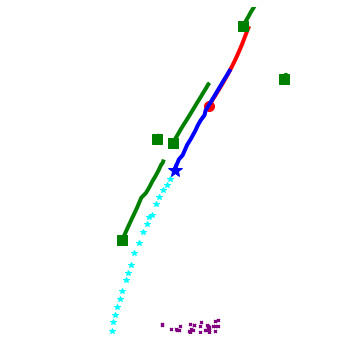

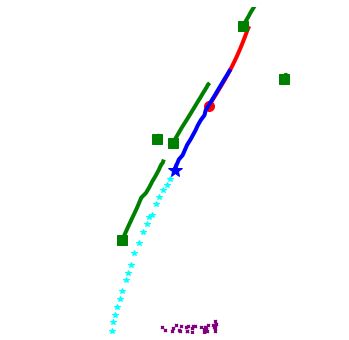

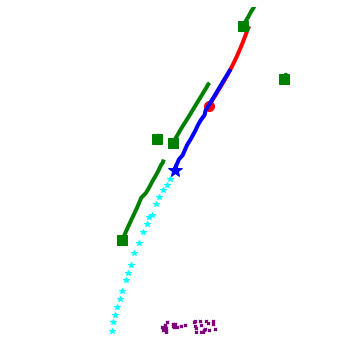

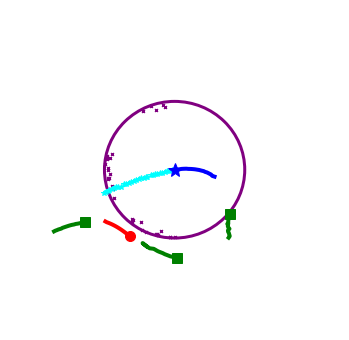

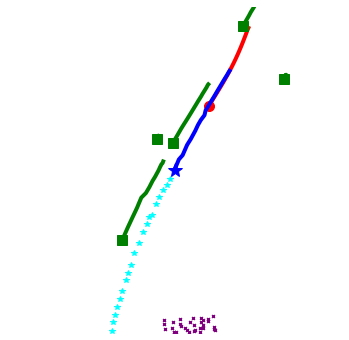

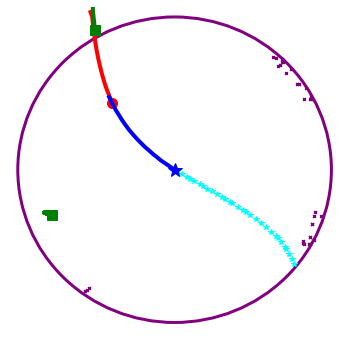

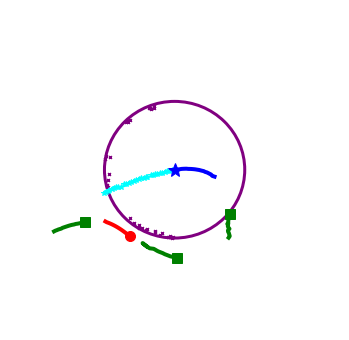

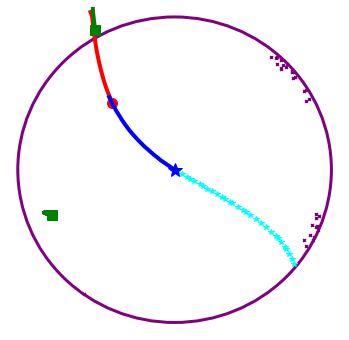

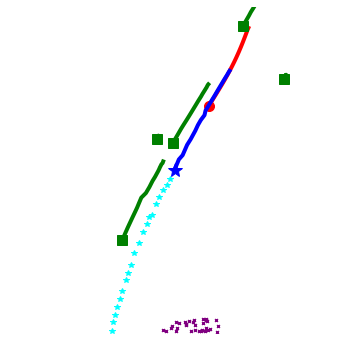

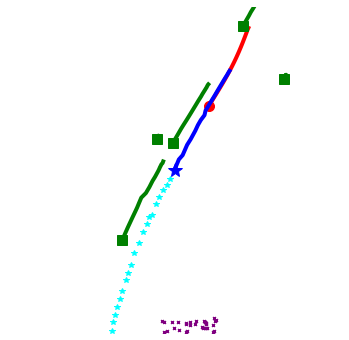

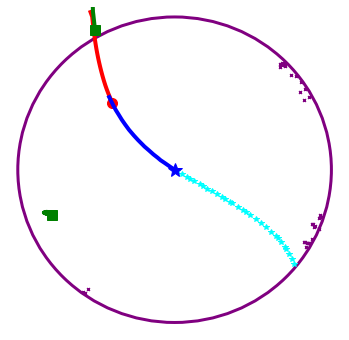

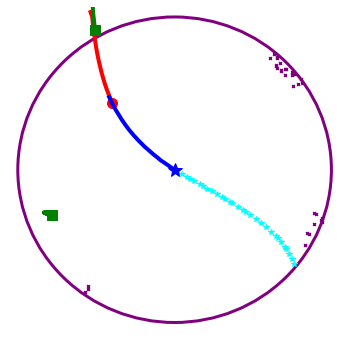

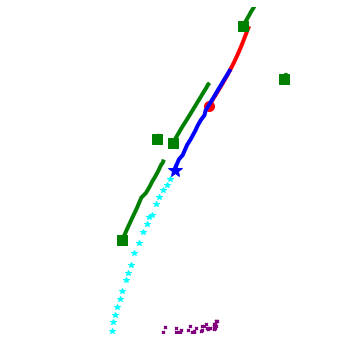

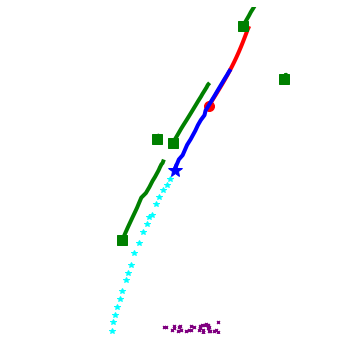

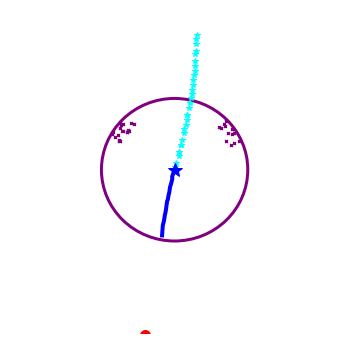

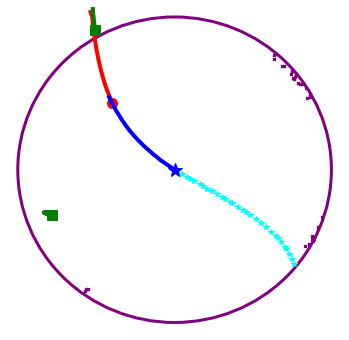

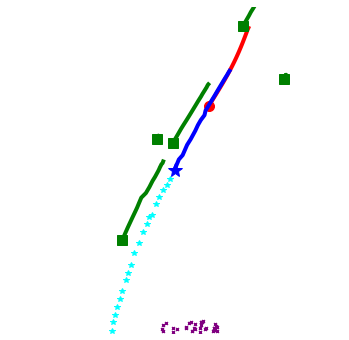

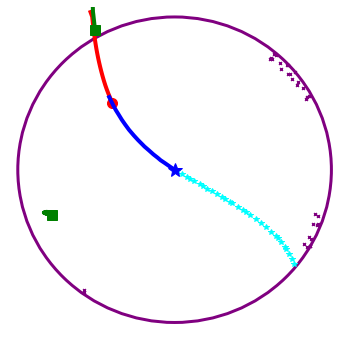

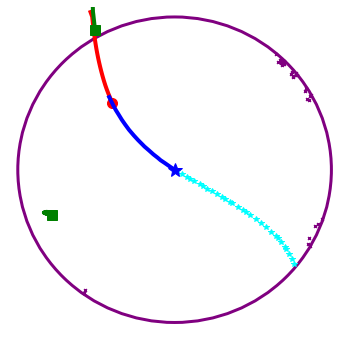

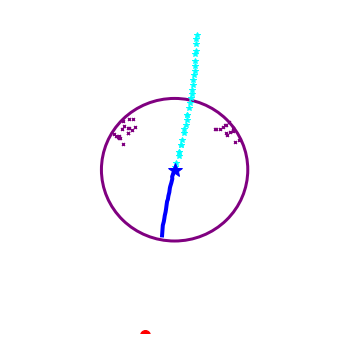

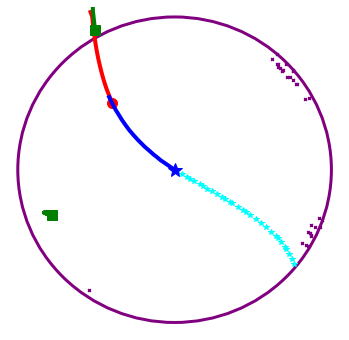

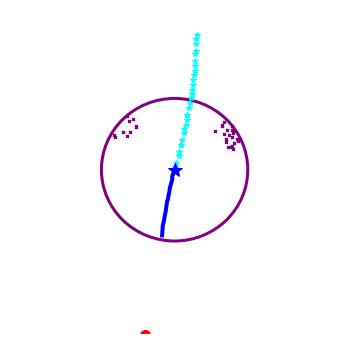

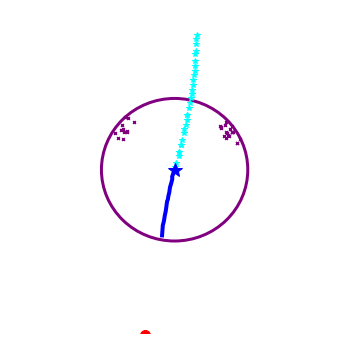

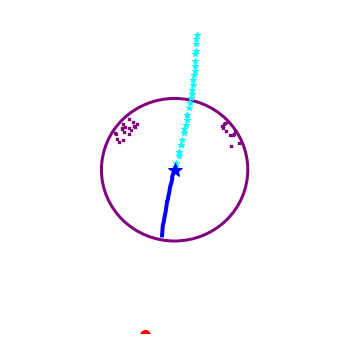

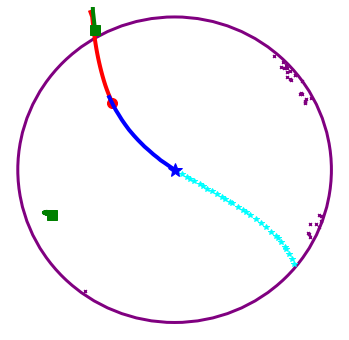

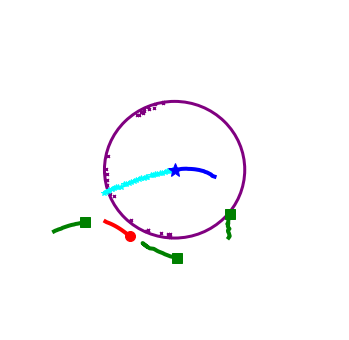

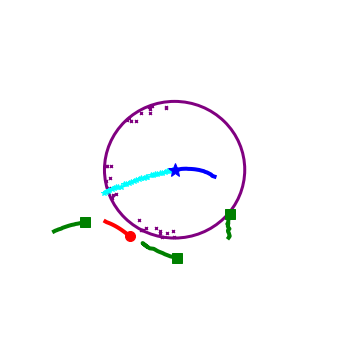

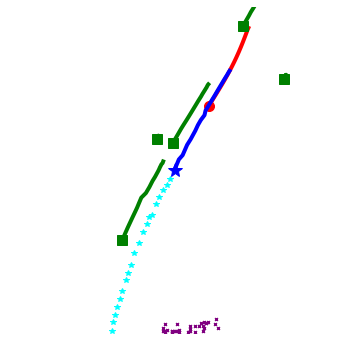

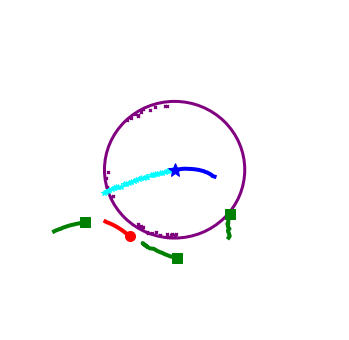

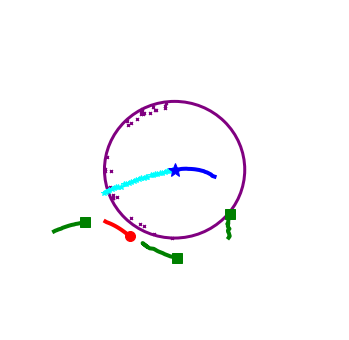

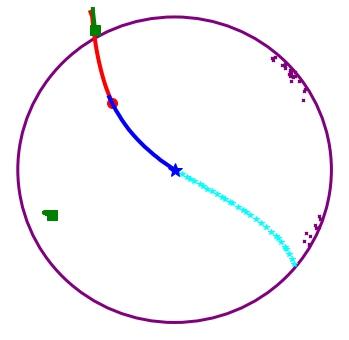

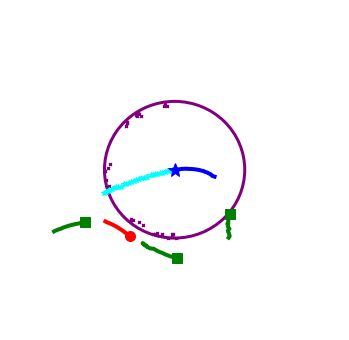

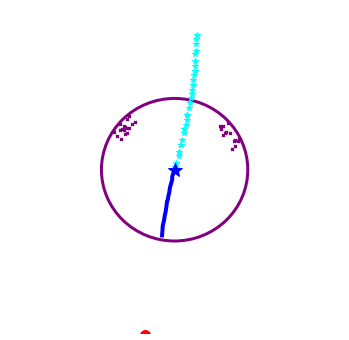

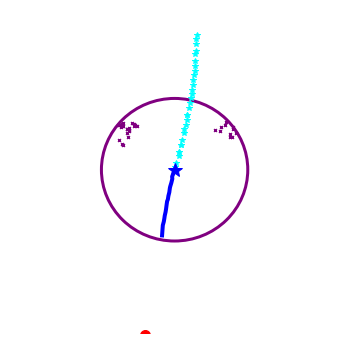

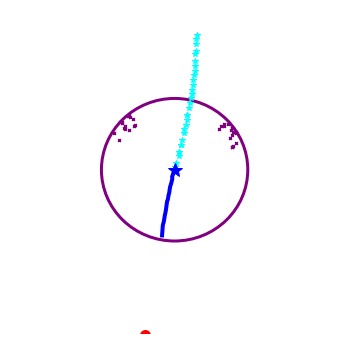

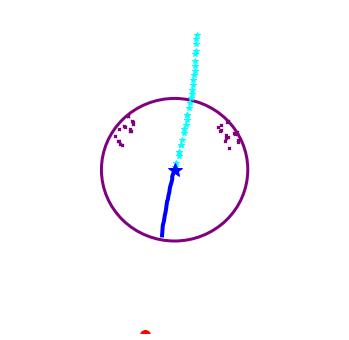

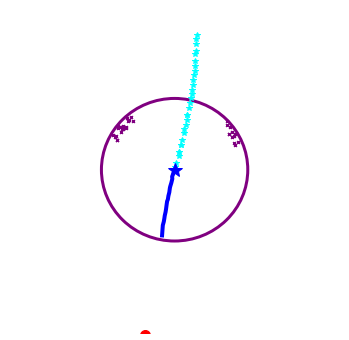

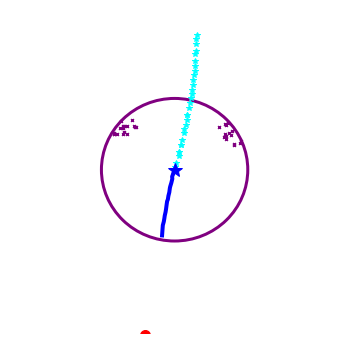

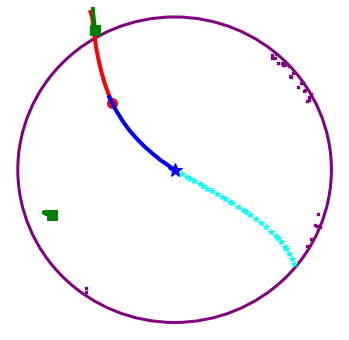

In [249]:
with torch.no_grad():
    for batch_index, batch in enumerate(loader):
        batch = [tensor.cuda() for tensor in batch]
        
        (obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_obj,
        loss_mask, seq_start_end, frames, object_cls, obj_id, ego_origin, num_seq,_) = batch

        predicted_traj = []
        pred_traj_fake_list = []

        print("Analizing sequence: ", num_seq.item())

        agent_idx = torch.where(object_cls==1)[0].cpu().numpy()
        traj_real = torch.cat([obs_traj, pred_traj_gt], dim=0)
        agent_traj_gt = pred_traj_gt[:,agent_idx,:] # From Multi to Single (30 x bs x 2)

        if PLOT_QUALITATIVE_RESULTS:
            filename = data_images_folder + "/" + str(num_seq.item()) + ".png"
            # img = map_functions.plot_qualitative_results_mm(filename, pred_traj_fake_list, agent_traj_gt, agent_idx,
            img = plot_qualitative_results_mm(filename, pred_traj_fake_list, agent_traj_gt, agent_idx,
                                                        object_cls, obs_traj, ego_origin, dist_rasterized_map)